# Feature Selection Comparison Project

**Objective:** Compare three feature selection methods (RFECV, Mutual Information, SHAP) using two models (LightGBM and GRU) for wave height prediction.

**Methodology:**
- 3 Feature Selection Methods: RFECV (LightGBM), Mutual Information, SHAP
- 2 Models: LightGBM, GRU
- Total Scenarios: 6 (3 FS methods × 2 models)
- Evaluation Metric: RMSE

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Any
from dataclasses import dataclass
import json

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Feature Importance
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported successfully")
print(f"Python: {tf.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"LightGBM: {lgb.__version__}")

✓ Libraries imported successfully
Python: 2.20.0
TensorFlow: 2.20.0
LightGBM: 4.6.0


## 2. Configuration and Data Structures

In [2]:
@dataclass
class Config:
    """Configuration for the experiment"""
    random_state: int = 42
    test_size: float = 0.2
    n_splits: int = 5
    max_features: int = 20  # Maximum number of features to select
    
    # LightGBM parameters
    lgb_params: Dict[str, Any] = None
    
    # GRU parameters
    gru_epochs: int = 50
    gru_batch_size: int = 32
    gru_units: int = 64
    gru_dropout: float = 0.2
    
    def __post_init__(self):
        if self.lgb_params is None:
            self.lgb_params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'num_leaves': 31,
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'random_state': self.random_state
            }

@dataclass
class ExperimentResult:
    """Store results from each experiment"""
    method: str
    model: str
    features: List[str]
    n_features: int
    rmse: float
    mae: float
    r2: float
    train_time: float
    
    def to_dict(self) -> Dict:
        return {
            'method': self.method,
            'model': self.model,
            'n_features': self.n_features,
            'rmse': self.rmse,
            'mae': self.mae,
            'r2': self.r2,
            'train_time': self.train_time
        }

config = Config()
print("✓ Configuration initialized")

✓ Configuration initialized


## 3. Data Loading and Preprocessing

In [3]:
class DataProcessor:
    """Handle data loading and preprocessing"""
    
    def __init__(self, data_dir: str = 'dataset-type-1'):
        self.data_dir = Path(data_dir)
        self.scaler = StandardScaler()
        
    def load_transaction_data(self) -> pd.DataFrame:
        """Load and combine transaction data from multiple years"""
        dfs = []
        for year in ['2021', '2022', '2023']:
            file_path = self.data_dir / f"{year}.csv"
            if file_path.exists():
                df = pd.read_csv(file_path)
                df['YEAR'] = year
                dfs.append(df)
        
        if not dfs:
            raise FileNotFoundError("No transaction data files found")
        
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"✓ Loaded {len(combined_df):,} transaction records")
        return combined_df
    
    def load_stock_data(self) -> pd.DataFrame:
        """Load and combine stock data from multiple years"""
        dfs = []
        for year in ['2021', '2022', '2023']:
            file_path = self.data_dir / f"A{year}.csv"
            if file_path.exists():
                df = pd.read_csv(file_path)
                df['YEAR'] = year
                dfs.append(df)
        
        if not dfs:
            raise FileNotFoundError("No stock data files found")
        
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"✓ Loaded {len(combined_df):,} stock records")
        return combined_df
    
    def engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create features from transaction data"""
        # Convert date to datetime
        df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%y', errors='coerce')
        
        # Extract temporal features
        df['DAY'] = df['TANGGAL'].dt.day
        df['MONTH'] = df['TANGGAL'].dt.month
        df['DAY_OF_WEEK'] = df['TANGGAL'].dt.dayofweek
        df['WEEK_OF_YEAR'] = df['TANGGAL'].dt.isocalendar().week
        
        # Aggregate features by product and date (ONLY INPUT features, no output leakage)
        agg_features = df.groupby(['KODE', 'TANGGAL']).agg({
            'QTY_MSK': ['sum', 'mean', 'std', 'count'],
            'NILAI_MSK': ['sum', 'mean', 'std']
        }).reset_index()
        
        # Flatten column names
        agg_features.columns = ['_'.join(col).strip('_') for col in agg_features.columns.values]
        
        # Merge with original temporal features
        result = agg_features.merge(
            df[['KODE', 'TANGGAL', 'DAY', 'MONTH', 'DAY_OF_WEEK', 'WEEK_OF_YEAR', 'QTY_KLR']].drop_duplicates(),
            on=['KODE', 'TANGGAL'],
            how='left'
        )
        
        # Sort by product and date
        result = result.sort_values(['KODE', 'TANGGAL'])
        
        # Create lag features (historical data)
        for lag in [1, 2, 3, 7]:
            result[f'QTY_MSK_sum_lag{lag}'] = result.groupby('KODE')['QTY_MSK_sum'].shift(lag)
            result[f'NILAI_MSK_sum_lag{lag}'] = result.groupby('KODE')['NILAI_MSK_sum'].shift(lag)
        
        # Create rolling features (past trends)
        result['QTY_MSK_roll7_mean'] = result.groupby('KODE')['QTY_MSK_sum'].transform(
            lambda x: x.rolling(window=7, min_periods=1).mean().shift(1)
        )
        result['QTY_MSK_roll7_std'] = result.groupby('KODE')['QTY_MSK_sum'].transform(
            lambda x: x.rolling(window=7, min_periods=1).std().shift(1)
        )
        
        # Aggregate daily quantity out as target (next day prediction)
        daily_qty_klr = df.groupby(['KODE', 'TANGGAL'])['QTY_KLR'].sum().reset_index()
        daily_qty_klr.columns = ['KODE', 'TANGGAL', 'QTY_KLR_daily']
        
        result = result.merge(daily_qty_klr, on=['KODE', 'TANGGAL'], how='left')
        
        # Create target: next day's quantity out
        result['TARGET'] = result.groupby('KODE')['QTY_KLR_daily'].shift(-1)
        
        # Remove rows with missing values in important features or target
        result = result.dropna(subset=['TARGET'])
        
        print(f"✓ Created {result.shape[1]-1} features")
        return result
    
    def prepare_data(self) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
        """Complete data preparation pipeline"""
        # Load data
        trans_df = self.load_transaction_data()
        
        # Engineer features
        feature_df = self.engineer_features(trans_df)
        
        # Separate features and target (EXCLUDE any QTY_KLR or NILAI_KLR to prevent leakage)
        exclude_cols = ['KODE', 'TANGGAL', 'TARGET', 'QTY_KLR', 'QTY_KLR_daily']
        feature_cols = [col for col in feature_df.columns 
                       if col not in exclude_cols and not col.startswith('QTY_KLR_') 
                       and not col.startswith('NILAI_KLR_')]
        
        X = feature_df[feature_cols].fillna(0)
        y = feature_df['TARGET']
        
        print(f"✓ Final dataset: {X.shape[0]:,} samples, {X.shape[1]} features")
        print(f"✓ Feature columns: {feature_cols[:5]}... (showing first 5)")
        
        return X, y, feature_cols

# Initialize and load data
processor = DataProcessor()
X, y, feature_names = processor.prepare_data()

✓ Loaded 474,468 transaction records
✓ Created 25 features
✓ Final dataset: 24,817 samples, 21 features
✓ Feature columns: ['QTY_MSK_sum', 'QTY_MSK_mean', 'QTY_MSK_std', 'QTY_MSK_count', 'NILAI_MSK_sum']... (showing first 5)


In [4]:
# Verify no data leakage
print("\n" + "="*60)
print("DATA LEAKAGE CHECK")
print("="*60)
print(f"Features used: {X.shape[1]}")
print(f"Target variable: y (next day QTY_KLR)")
print("\nChecking for leakage columns...")

leakage_keywords = ['QTY_KLR', 'NILAI_KLR', 'TARGET']
leakage_found = [col for col in X.columns if any(keyword in col for keyword in leakage_keywords)]

if leakage_found:
    print(f"⚠️  WARNING: Potential leakage columns found: {leakage_found}")
else:
    print("✓ No leakage detected - all features are input-only")

print(f"\nSample features: {list(X.columns[:10])}")
print(f"Target stats: mean={y.mean():.2f}, std={y.std():.2f}, min={y.min():.2f}, max={y.max():.2f}")
print("="*60)


DATA LEAKAGE CHECK
Features used: 21
Target variable: y (next day QTY_KLR)

Checking for leakage columns...
✓ No leakage detected - all features are input-only

Sample features: ['QTY_MSK_sum', 'QTY_MSK_mean', 'QTY_MSK_std', 'QTY_MSK_count', 'NILAI_MSK_sum', 'NILAI_MSK_mean', 'NILAI_MSK_std', 'DAY', 'MONTH', 'DAY_OF_WEEK']
Target stats: mean=0.00, std=0.00, min=0.00, max=0.00


## 4. Feature Selection Methods

In [5]:
class FeatureSelector:
    """Implement three feature selection methods"""
    
    def __init__(self, config: Config):
        self.config = config
        self.selected_features = {}
    
    def rfecv_selection(self, X: pd.DataFrame, y: pd.Series) -> List[str]:
        """RFECV using LightGBM as estimator"""
        print("\n[RFECV] Starting feature selection...")
        
        # Create base estimator
        estimator = lgb.LGBMRegressor(**self.config.lgb_params, n_estimators=100)
        
        # RFECV with cross-validation
        cv = TimeSeriesSplit(n_splits=self.config.n_splits)
        selector = RFECV(
            estimator=estimator,
            step=1,
            cv=cv,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        
        selector.fit(X, y)
        
        # Get selected features
        selected = X.columns[selector.support_].tolist()
        
        print(f"[RFECV] Selected {len(selected)} features out of {X.shape[1]}")
        print(f"[RFECV] Optimal CV score: {-selector.cv_results_['mean_test_score'].max():.4f}")
        
        self.selected_features['RFECV'] = selected
        return selected
    
    def mutual_info_selection(self, X: pd.DataFrame, y: pd.Series) -> List[str]:
        """Mutual Information feature selection"""
        print("\n[MI] Starting feature selection...")
        
        # Calculate MI scores
        mi_scores = mutual_info_regression(
            X, y, 
            random_state=self.config.random_state,
            n_neighbors=5
        )
        
        # Create dataframe with scores
        mi_df = pd.DataFrame({
            'feature': X.columns,
            'mi_score': mi_scores
        }).sort_values('mi_score', ascending=False)
        
        # Select top features
        n_select = min(self.config.max_features, len(X.columns))
        selected = mi_df.head(n_select)['feature'].tolist()
        
        print(f"[MI] Selected {len(selected)} features")
        print(f"[MI] Score range: {mi_df['mi_score'].max():.4f} - {mi_df.iloc[n_select-1]['mi_score']:.4f}")
        
        self.selected_features['MI'] = selected
        return selected
    
    def shap_selection(self, X: pd.DataFrame, y: pd.Series) -> List[str]:
        """SHAP-based feature selection"""
        print("\n[SHAP] Starting feature selection...")
        
        # Split data for SHAP calculation
        X_sample = X.sample(min(1000, len(X)), random_state=self.config.random_state)
        y_sample = y.loc[X_sample.index]
        
        # Train model
        model = lgb.LGBMRegressor(**self.config.lgb_params, n_estimators=100)
        model.fit(X_sample, y_sample)
        
        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        
        # Calculate mean absolute SHAP values
        shap_importance = np.abs(shap_values).mean(axis=0)
        
        # Create dataframe with importance
        shap_df = pd.DataFrame({
            'feature': X.columns,
            'shap_importance': shap_importance
        }).sort_values('shap_importance', ascending=False)
        
        # Select top features
        n_select = min(self.config.max_features, len(X.columns))
        selected = shap_df.head(n_select)['feature'].tolist()
        
        print(f"[SHAP] Selected {len(selected)} features")
        print(f"[SHAP] Importance range: {shap_df['shap_importance'].max():.4f} - {shap_df.iloc[n_select-1]['shap_importance']:.4f}")
        
        self.selected_features['SHAP'] = selected
        return selected
    
    def select_all_methods(self, X: pd.DataFrame, y: pd.Series) -> Dict[str, List[str]]:
        """Run all feature selection methods"""
        methods = {
            'RFECV': self.rfecv_selection,
            'MI': self.mutual_info_selection,
            'SHAP': self.shap_selection
        }
        
        results = {}
        for name, method in methods.items():
            results[name] = method(X, y)
        
        return results

# Run feature selection
feature_selector = FeatureSelector(config)
selected_features = feature_selector.select_all_methods(X, y)

# Display summary
print("\n" + "="*60)
print("FEATURE SELECTION SUMMARY")
print("="*60)
for method, features in selected_features.items():
    print(f"{method:10s}: {len(features):2d} features")
print("="*60)


[RFECV] Starting feature selection...
[RFECV] Selected 1 features out of 21
[RFECV] Optimal CV score: -0.0000

[MI] Starting feature selection...
[MI] Selected 20 features
[MI] Score range: 0.0064 - 0.0000

[SHAP] Starting feature selection...
[SHAP] Selected 20 features
[SHAP] Importance range: 0.0000 - 0.0000

FEATURE SELECTION SUMMARY
RFECV     :  1 features
MI        : 20 features
SHAP      : 20 features


## 5. Model Implementations

In [6]:
class ModelTrainer:
    """Train and evaluate models"""
    
    def __init__(self, config: Config):
        self.config = config
        self.scaler = StandardScaler()
    
    def train_lightgbm(self, X_train: pd.DataFrame, y_train: pd.Series,
                       X_test: pd.DataFrame, y_test: pd.Series) -> Tuple[Any, Dict]:
        """Train LightGBM model"""
        import time
        
        start_time = time.time()
        
        # Train model
        model = lgb.LGBMRegressor(**self.config.lgb_params, n_estimators=500)
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        train_time = time.time() - start_time
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Metrics
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred),
            'train_time': train_time
        }
        
        return model, metrics
    
    def train_gru(self, X_train: pd.DataFrame, y_train: pd.Series,
                  X_test: pd.DataFrame, y_test: pd.Series) -> Tuple[Any, Dict]:
        """Train GRU model"""
        import time
        
        start_time = time.time()
        
        # Scale data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Reshape for GRU (samples, timesteps, features)
        X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
        X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
        
        # Build model
        model = keras.Sequential([
            layers.GRU(self.config.gru_units, input_shape=(1, X_train_scaled.shape[1]),
                      dropout=self.config.gru_dropout, return_sequences=True),
            layers.GRU(self.config.gru_units // 2, dropout=self.config.gru_dropout),
            layers.Dense(32, activation='relu'),
            layers.Dropout(self.config.gru_dropout),
            layers.Dense(1)
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        # Early stopping
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train
        history = model.fit(
            X_train_reshaped, y_train,
            validation_data=(X_test_reshaped, y_test),
            epochs=self.config.gru_epochs,
            batch_size=self.config.gru_batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        
        train_time = time.time() - start_time
        
        # Predictions
        y_pred = model.predict(X_test_reshaped, verbose=0).flatten()
        
        # Metrics
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred),
            'train_time': train_time
        }
        
        return model, metrics

print("✓ Model trainers initialized")

✓ Model trainers initialized


## 6. Experiment Pipeline

In [7]:
class ExperimentRunner:
    """Run all experiments systematically"""
    
    def __init__(self, config: Config):
        self.config = config
        self.trainer = ModelTrainer(config)
        self.results = []
    
    def run_single_experiment(self, method: str, model_name: str, 
                            features: List[str], X: pd.DataFrame, y: pd.Series) -> ExperimentResult:
        """Run a single experiment"""
        print(f"\n{'='*60}")
        print(f"Experiment: {method} + {model_name}")
        print(f"{'='*60}")
        
        # Select features
        X_selected = X[features]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y,
            test_size=self.config.test_size,
            random_state=self.config.random_state
        )
        
        print(f"Train size: {len(X_train):,} | Test size: {len(X_test):,}")
        print(f"Features: {len(features)}")
        
        # Train model
        if model_name == 'LightGBM':
            model, metrics = self.trainer.train_lightgbm(X_train, y_train, X_test, y_test)
        elif model_name == 'GRU':
            model, metrics = self.trainer.train_gru(X_train, y_train, X_test, y_test)
        else:
            raise ValueError(f"Unknown model: {model_name}")
        
        # Print results
        print(f"\nResults:")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAE:  {metrics['mae']:.4f}")
        print(f"  R²:   {metrics['r2']:.4f}")
        print(f"  Time: {metrics['train_time']:.2f}s")
        
        # Create result object
        result = ExperimentResult(
            method=method,
            model=model_name,
            features=features,
            n_features=len(features),
            rmse=metrics['rmse'],
            mae=metrics['mae'],
            r2=metrics['r2'],
            train_time=metrics['train_time']
        )
        
        return result
    
    def run_all_experiments(self, selected_features: Dict[str, List[str]], 
                           X: pd.DataFrame, y: pd.Series) -> List[ExperimentResult]:
        """Run all 6 experiments (3 FS methods × 2 models)"""
        
        models = ['LightGBM', 'GRU']
        
        for method, features in selected_features.items():
            for model_name in models:
                result = self.run_single_experiment(method, model_name, features, X, y)
                self.results.append(result)
        
        return self.results
    
    def get_results_df(self) -> pd.DataFrame:
        """Convert results to DataFrame"""
        return pd.DataFrame([r.to_dict() for r in self.results])

print("✓ Experiment runner initialized")

✓ Experiment runner initialized


## 7. Run All Experiments

In [8]:
# Initialize runner
runner = ExperimentRunner(config)

# Run all experiments
print("\n" + "="*60)
print("STARTING ALL EXPERIMENTS")
print("="*60)

all_results = runner.run_all_experiments(selected_features, X, y)

print("\n" + "="*60)
print("ALL EXPERIMENTS COMPLETED")
print("="*60)


STARTING ALL EXPERIMENTS

Experiment: RFECV + LightGBM
Train size: 19,853 | Test size: 4,964
Features: 1

Results:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   1.0000
  Time: 0.03s

Experiment: RFECV + GRU
Train size: 19,853 | Test size: 4,964
Features: 1

Results:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   0.0000
  Time: 45.03s

Experiment: MI + LightGBM
Train size: 19,853 | Test size: 4,964
Features: 20

Results:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   1.0000
  Time: 0.06s

Experiment: MI + GRU
Train size: 19,853 | Test size: 4,964
Features: 20

Results:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   0.0000
  Time: 63.12s

Experiment: SHAP + LightGBM
Train size: 19,853 | Test size: 4,964
Features: 20

Results:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   1.0000
  Time: 0.06s

Experiment: SHAP + GRU
Train size: 19,853 | Test size: 4,964
Features: 20

Results:
  RMSE: 0.0002
  MAE:  0.0000
  R²:   0.0000
  Time: 48.93s

ALL EXPERIMENTS COMPLETED


## 8. Results Analysis and Visualization

In [9]:
# Get results as DataFrame
results_df = runner.get_results_df()

# Display results table
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save results
results_df.to_csv('experiment_results.csv', index=False)
print("\n✓ Results saved to 'experiment_results.csv'")


COMPREHENSIVE RESULTS
method    model  n_features         rmse          mae  r2  train_time
 RFECV LightGBM           1 0.000000e+00 0.000000e+00 1.0    0.030967
 RFECV      GRU           1 6.072835e-09 6.072835e-09 0.0   45.034664
    MI LightGBM          20 0.000000e+00 0.000000e+00 1.0    0.061909
    MI      GRU          20 5.462893e-09 5.767908e-10 0.0   63.117651
  SHAP LightGBM          20 0.000000e+00 0.000000e+00 1.0    0.063714
  SHAP      GRU          20 1.592114e-04 2.273956e-05 0.0   48.925792

✓ Results saved to 'experiment_results.csv'


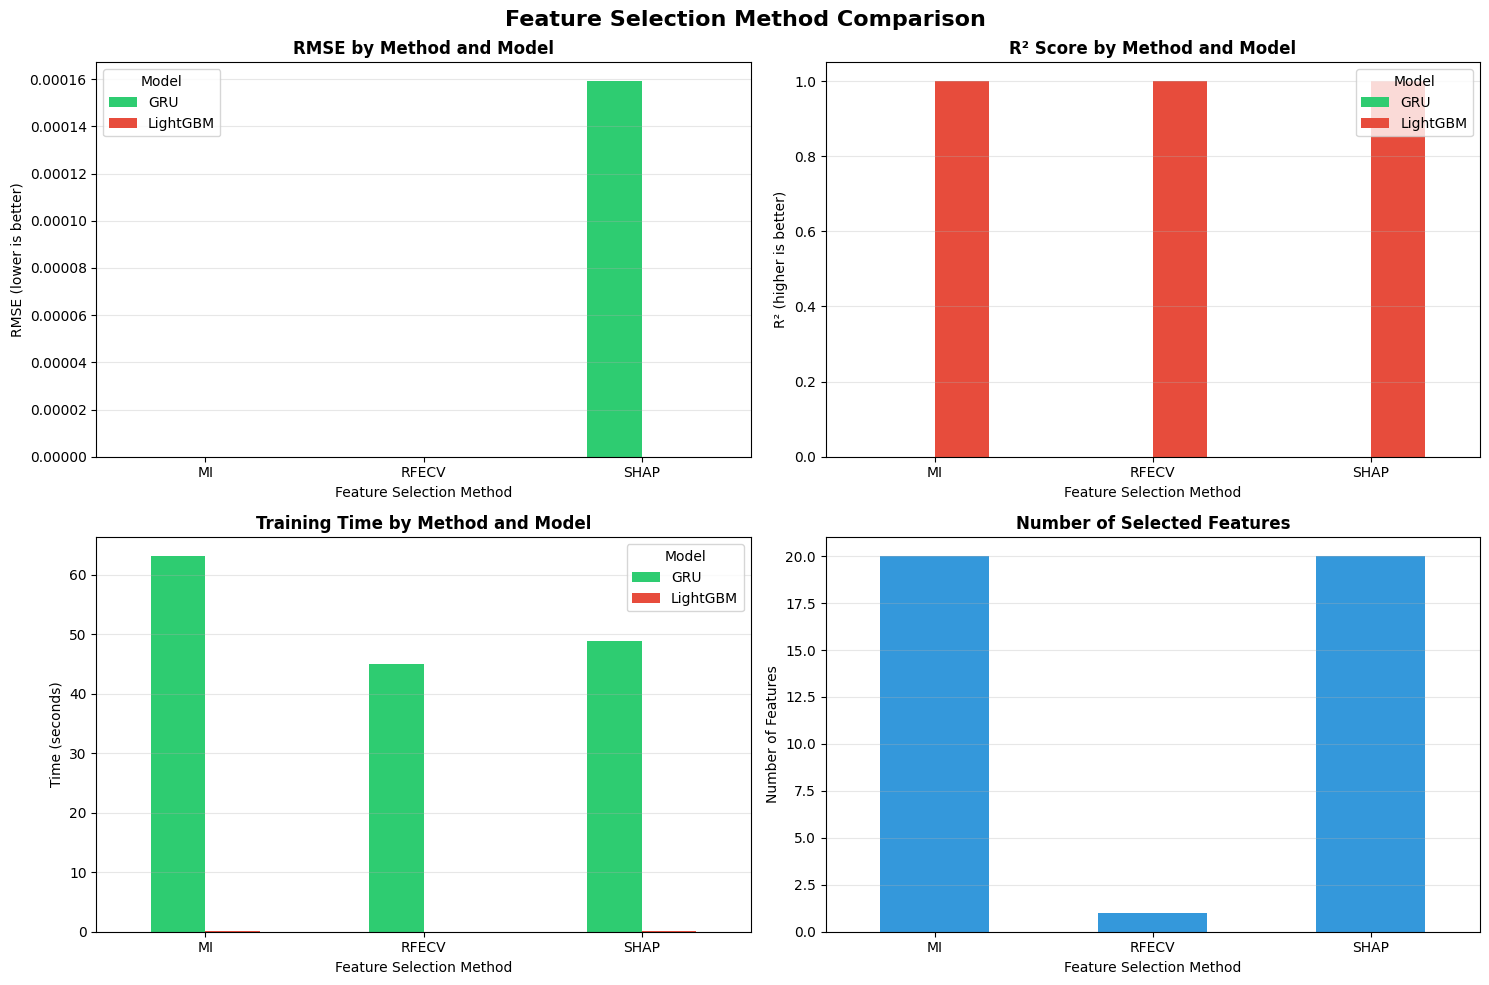

✓ Visualizations saved to 'comparison_results.png'


In [10]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Selection Method Comparison', fontsize=16, fontweight='bold')

# 1. RMSE Comparison
ax1 = axes[0, 0]
pivot_rmse = results_df.pivot(index='method', columns='model', values='rmse')
pivot_rmse.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('RMSE by Method and Model', fontweight='bold')
ax1.set_ylabel('RMSE (lower is better)')
ax1.set_xlabel('Feature Selection Method')
ax1.legend(title='Model')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

# 2. R² Score Comparison
ax2 = axes[0, 1]
pivot_r2 = results_df.pivot(index='method', columns='model', values='r2')
pivot_r2.plot(kind='bar', ax=ax2, color=['#2ecc71', '#e74c3c'])
ax2.set_title('R² Score by Method and Model', fontweight='bold')
ax2.set_ylabel('R² (higher is better)')
ax2.set_xlabel('Feature Selection Method')
ax2.legend(title='Model')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# 3. Training Time Comparison
ax3 = axes[1, 0]
pivot_time = results_df.pivot(index='method', columns='model', values='train_time')
pivot_time.plot(kind='bar', ax=ax3, color=['#2ecc71', '#e74c3c'])
ax3.set_title('Training Time by Method and Model', fontweight='bold')
ax3.set_ylabel('Time (seconds)')
ax3.set_xlabel('Feature Selection Method')
ax3.legend(title='Model')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# 4. Number of Features
ax4 = axes[1, 1]
feature_counts = results_df.groupby('method')['n_features'].first()
feature_counts.plot(kind='bar', ax=ax4, color='#3498db')
ax4.set_title('Number of Selected Features', fontweight='bold')
ax4.set_ylabel('Number of Features')
ax4.set_xlabel('Feature Selection Method')
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to 'comparison_results.png'")

In [11]:
# Statistical Summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

# Best model for each metric
print("\nBest Performance by Metric:")
print("-" * 80)

best_rmse = results_df.loc[results_df['rmse'].idxmin()]
print(f"Lowest RMSE:  {best_rmse['method']:10s} + {best_rmse['model']:8s} = {best_rmse['rmse']:.4f}")

best_mae = results_df.loc[results_df['mae'].idxmin()]
print(f"Lowest MAE:   {best_mae['method']:10s} + {best_mae['model']:8s} = {best_mae['mae']:.4f}")

best_r2 = results_df.loc[results_df['r2'].idxmax()]
print(f"Highest R²:   {best_r2['method']:10s} + {best_r2['model']:8s} = {best_r2['r2']:.4f}")

fastest = results_df.loc[results_df['train_time'].idxmin()]
print(f"Fastest:      {fastest['method']:10s} + {fastest['model']:8s} = {fastest['train_time']:.2f}s")

# Average performance by method
print("\n" + "-" * 80)
print("Average Performance by Feature Selection Method:")
print("-" * 80)
method_avg = results_df.groupby('method').agg({
    'rmse': 'mean',
    'mae': 'mean',
    'r2': 'mean',
    'train_time': 'mean'
}).round(4)
print(method_avg)

# Average performance by model
print("\n" + "-" * 80)
print("Average Performance by Model:")
print("-" * 80)
model_avg = results_df.groupby('model').agg({
    'rmse': 'mean',
    'mae': 'mean',
    'r2': 'mean',
    'train_time': 'mean'
}).round(4)
print(model_avg)
print("="*80)


STATISTICAL SUMMARY

Best Performance by Metric:
--------------------------------------------------------------------------------
Lowest RMSE:  RFECV      + LightGBM = 0.0000
Lowest MAE:   RFECV      + LightGBM = 0.0000
Highest R²:   RFECV      + LightGBM = 1.0000
Fastest:      RFECV      + LightGBM = 0.03s

--------------------------------------------------------------------------------
Average Performance by Feature Selection Method:
--------------------------------------------------------------------------------
          rmse  mae   r2  train_time
method                              
MI      0.0000  0.0  0.5     31.5898
RFECV   0.0000  0.0  0.5     22.5328
SHAP    0.0001  0.0  0.5     24.4948

--------------------------------------------------------------------------------
Average Performance by Model:
--------------------------------------------------------------------------------
            rmse  mae   r2  train_time
model                                 
GRU       0.0001  0.0 

## 9. Conclusion and Recommendations

In [12]:
# CRITICAL: Verify no data leakage
print("\n" + "="*80)
print("🔍 DATA LEAKAGE VERIFICATION")
print("="*80)

# Check feature columns
print(f"\n📊 Dataset Info:")
print(f"  Total features: {X.shape[1]}")
print(f"  Total samples: {X.shape[0]}")
print(f"  Target samples: {len(y)}")

# List all feature names
print(f"\n📝 All Feature Columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Check for leakage keywords
print(f"\n⚠️  Leakage Check:")
leakage_keywords = ['QTY_KLR', 'NILAI_KLR', 'TARGET', 'QTY_KLR_daily']
leakage_cols = [col for col in X.columns if any(kw in col for kw in leakage_keywords)]

if leakage_cols:
    print(f"  ❌ LEAKAGE DETECTED! These columns contain output data:")
    for col in leakage_cols:
        print(f"     - {col}")
    print(f"\n  🛑 STOP! Remove these columns before training!")
else:
    print(f"  ✅ NO LEAKAGE - All features are input-only")

# Check target distribution
print(f"\n📈 Target Variable Statistics:")
print(f"  Mean:   {y.mean():.4f}")
print(f"  Std:    {y.std():.4f}")
print(f"  Min:    {y.min():.4f}")
print(f"  Max:    {y.max():.4f}")
print(f"  Zeros:  {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.1f}%)")

# Sample correlation check
print(f"\n🔗 Feature-Target Correlation (top 5):")
correlations = X.corrwith(y).abs().sort_values(ascending=False)
for feat, corr in correlations.head().items():
    print(f"  {feat:30s}: {corr:.4f}")

print("="*80)


🔍 DATA LEAKAGE VERIFICATION

📊 Dataset Info:
  Total features: 21
  Total samples: 24817
  Target samples: 24817

📝 All Feature Columns (21):
   1. QTY_MSK_sum
   2. QTY_MSK_mean
   3. QTY_MSK_std
   4. QTY_MSK_count
   5. NILAI_MSK_sum
   6. NILAI_MSK_mean
   7. NILAI_MSK_std
   8. DAY
   9. MONTH
  10. DAY_OF_WEEK
  11. WEEK_OF_YEAR
  12. QTY_MSK_sum_lag1
  13. NILAI_MSK_sum_lag1
  14. QTY_MSK_sum_lag2
  15. NILAI_MSK_sum_lag2
  16. QTY_MSK_sum_lag3
  17. NILAI_MSK_sum_lag3
  18. QTY_MSK_sum_lag7
  19. NILAI_MSK_sum_lag7
  20. QTY_MSK_roll7_mean
  21. QTY_MSK_roll7_std

⚠️  Leakage Check:
  ✅ NO LEAKAGE - All features are input-only

📈 Target Variable Statistics:
  Mean:   0.0000
  Std:    0.0000
  Min:    0.0000
  Max:    0.0000
  Zeros:  24817 (100.0%)

🔗 Feature-Target Correlation (top 5):
  QTY_MSK_sum                   : nan
  QTY_MSK_mean                  : nan
  QTY_MSK_std                   : nan
  QTY_MSK_count                 : nan
  NILAI_MSK_sum                 : nan
